## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
import os
import torch
from pathlib import Path
from shutil import copy
from torch import optim, nn
import torch.nn.functional as F
from socket import gethostname
import time

%matplotlib inline 
import matplotlib.pyplot as plt

from torchsummary import summary  # install with 'pip install torchsummary'
from tensorboardX import SummaryWriter


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import json


def plot_images(X, labels):
    num_plots = X.shape[0]
    w_min, w_max = np.min(X), np.max(X)

    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    for i in range(num_plots):
        plt.subplot(3, 3, i + 1)

        # Rescale the weights to be between 0 and 255
        img = 255.0 * (X[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
        plt.title(classes[labels[i].item()])


def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=0,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)


def plot_weights(w, scaling=False):
    if w.shape[1] != 3:
        print('Cannot visualize filter with this dimensions: {}!'.format(w[0, :, :, :].shape))

    else:
        num_plots = w.shape[0]

        # plot positive weight entries
        plt.figure(num=None, figsize=(14, 6), dpi=80)
        for i in range(num_plots):
            plt.subplot(1, num_plots, i + 1)

            # Rescale the weights to be between 0 and 255
            img = w[i, :, :, :].squeeze().clip(0, 1)
            if scaling:
                img -= np.min(img)
                img /= np.max(img)
            img *= 255.
            plt.imshow(img.transpose().astype('uint8'))
            plt.axis('off')
            plt.title(str(i))
        plt.show()

        # plot negative weight entries
        plt.figure(num=None, figsize=(14, 6), dpi=80)
        for i in range(num_plots):
            plt.subplot(1, num_plots, i + 1)

            # Rescale the weights to be between 0 and 255
            img = w[i, :, :, :].squeeze().clip(-1, 0) * (-1)
            if scaling:
                img -= np.min(img)
                img /= np.max(img)
            img *= 255.
            plt.imshow(img.transpose().astype('uint8'))
            plt.axis('off')
            plt.title(str(i))
        plt.show()


def plot_gradient_flow(named_parameters):
    """
    Vizualize the gradient propagation through the neural net.

    """

    ave_grads = []
    max_grads = []
    layers = []

    for n, p in named_parameters:
        if (p.requires_grad) and ('bias' not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color='r')
    plt.bar(np.arange(len(ave_grads)), ave_grads, alpha=0.1, lw=1, color='b')
    plt.hlines(0, 0, len(ave_grads) + 1, lw=2, color='k')
    plt.xticks(range(len(ave_grads) + 1), layers, rotation='vertical')
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient")
    plt.title("Gradient Flow")


Files already downloaded and verified
Files already downloaded and verified


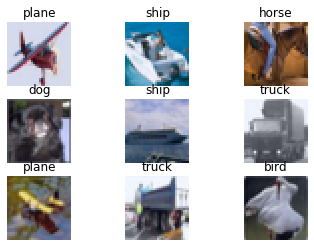

In [3]:
# get data loaders
trainloader, valloader = get_train_valid_loader()

In [5]:
class ConvNet(nn.Module):
    # Tested with lr = 1e-3, l2_reg = 1e-2
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()

        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################

        self.conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=32, kernel_size=5, padding=2)
        self.conv1_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=(64 * 8 * 8), out_features=96)
        self.fc2 = nn.Linear(in_features=96, out_features=n_output)

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1_1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_1(x))
        x = self.maxpool(x)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        return x

    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)
# plot net parameters
net = ConvNet()

summary(net, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
            Conv2d-2           [-1, 32, 32, 32]          25,632
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
            Conv2d-5           [-1, 64, 16, 16]          36,928
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                   [-1, 96]         393,312
            Linear-8                   [-1, 10]             970
Total params: 477,770
Trainable params: 477,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 1.82
Estimated Total Size (MB): 2.68
----------------------------------------------------------------


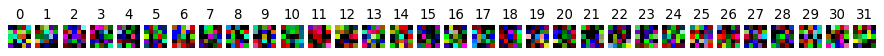

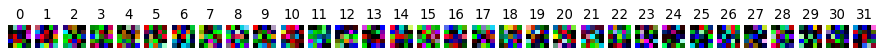

In [6]:
# visualize init weights
w = net.conv1.weight.data.numpy()
plot_weights(w,scaling=True)

In [10]:
CONFIG = {
  "parameters": {
    "model": "ConvNet_Type4",
    "epochs": 3,
    "lr": 1e-3,
    "lr_decay_rate": 0.1,
    "lr_decay_patience": 3,
    "lr_decay_threshold": 1e-2,
    "l2_reg": 1e-2,
    "results": "runs"
  }
}

In [14]:
# create output directory

# copy models.py and config file for documentation


# set optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=CONFIG['parameters']['lr'], weight_decay=CONFIG['parameters']['l2_reg'])

# https://discuss.pytorch.org/t/how-to-do-exponential-learning-rate-decay-in-pytorch/63146/3
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, 
    factor=CONFIG['parameters']['lr_decay_rate'], 
    patience=CONFIG['parameters']['lr_decay_patience'], 
    threshold=CONFIG['parameters']['lr_decay_threshold'], 
    verbose = True)


epochs = CONFIG['parameters']['epochs']
running_loss = 0
print_every = 200
training_steps = 0

# init tensorboard writer
writer = SummaryWriter(log_dir='./')

val_acc_best = 0

for e in range(epochs):
    
    print('\n--- EPOCH %03d / %03d STARTED ---' % (e+1, epochs))
 
    # set net to train mode
    net.train()
    
    # log current learning rate
    writer.add_scalar('optimizer/learning_rate', optimizer.param_groups[0]['lr'], e+1)
    
    # train over all batches
    start = time.time()
    for idx_batch, (images, labels) in enumerate(trainloader):
        
        training_steps += 1
        
        if idx_batch % print_every == 0:
            print('---> train on batch %03d' % idx_batch)
        
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        
        writer.add_scalar('train/loss_training_step', loss.item(), training_steps)
        
    # visualize gradients   
    plot_gradient_flow(net.named_parameters())

    # set net to evaluation mode
    net.eval()
    
    # evaluate on training data 
    train_loss_accum = 0.
    count_total = 0
    count_correct = 0
    for idx_batch, (images, labels) in enumerate(trainloader):
        output = net(images)
        loss = criterion(output, labels)
        train_loss_accum += loss.item()
        
        prediction = torch.argmax(F.softmax(output), axis=1)
        count_total += prediction.size(0)
        count_correct += (prediction == labels).sum().item()
        
    train_loss_avg = train_loss_accum / (idx_batch+1)
    train_acc = count_correct / count_total
    writer.add_scalar('train/loss_epoch', train_loss_avg, e+1)
    writer.add_scalar('train/accuracy', train_acc, e+1)
    
    # evaluate on validation data 
    val_loss_accum = 0.
    count_total = 0
    count_correct = 0
    for idx_batch, (images, labels) in enumerate(valloader):
        output = net(images)
        loss = criterion(output, labels)
        val_loss_accum += loss.item()
        
        prediction = torch.argmax(F.softmax(output), axis=1)
        count_total += prediction.size(0)
        count_correct += (prediction == labels).sum().item()

    val_loss_avg = val_loss_accum / (idx_batch+1)
    val_acc = count_correct / count_total
    writer.add_scalar('val/loss_epoch', val_loss_avg, e+1)
    writer.add_scalar('val/accuracy', val_acc, e+1)
    
    writer.add_scalar('val/train_val_loss_ratio', val_loss_avg-train_loss_avg, e+1)
    
    print('\nMetrics: ')
    print('---> train loss / accuracy: %.03f / %.03f' % (train_loss_avg, train_acc))
    print('---> val loss / accuracy:   %.03f / %.03f' % (val_loss_avg, val_acc))
    
    scheduler.step(val_loss_avg)
    
    print('filters conv1')
    w1 = net.conv1.weight.data.numpy()
    plot_weights(w1, scaling=True)
    plt.show()
    
    if val_acc > val_acc_best:
        val_acc_best = val_acc
        print('---> save new best checkpoint')
        #torch.save(net.state_dict(), filepath_ckpt)

# close tensorboard logging
writer.close()


--- EPOCH 001 / 003 STARTED ---
---> train on batch 000


KeyboardInterrupt: 

Save best trained model.